In [2]:
import numpy as np
import pandas as pd
import scanpy.api as sc
import anndata
import wget
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures
sc.logging.print_versions()

/Users/iwes/anaconda3/envs/tf/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Loaded backend module://ipykernel.pylab.backend_inline version unknown.
scanpy==1.2.2+166.g6c1daba anndata==0.6.9 numpy==1.14.2 scipy==1.0.1 pandas==0.22.0 scikit-learn==0.19.1 statsmodels==0.8.0 python-igraph==0.7.1 louvain==0.6.1 
Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [2]:
%load_ext rpy2.ipython

In [4]:
%%R

if (!('Seurat' %in% rownames(installed.packages())))
{
    install.packages("Seurat")
}

/Users/iwes/anaconda3/envs/tf/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: also installing the dependencies ‘gbRd’, ‘lsei’, ‘Rdpack’, ‘npsurv’, ‘ROCR’, ‘lars’, ‘ica’, ‘tsne’, ‘pbapply’, ‘dtw’, ‘SDMTools’, ‘metap’, ‘fitdistrplus’, ‘doSNOW’, ‘reticulate’, ‘hdf5r’, ‘RcppProgress’


  warnings.warn(x, RRuntimeWarning)
/Users/iwes/anaconda3/envs/tf/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'https://cran.pau.edu.tr/bin/macosx/el-capitan/contrib/3.5/gbRd_0.4-11.tgz'

  warnings.warn(x, RRuntimeWarning)
/Users/iwes/anaconda3/envs/tf/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Content type 'application/x-gzip'
  warnings.warn(x, RRuntimeWarning)
/Users/iwes/anaconda3/envs/tf/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 42743 bytes (41 KB)

  warnings.warn(x, RRuntimeWarning)
/Users/iwes/anaconda3/envs/tf/lib/python3.6/site-packages/rpy2/rinte

/Users/iwes/anaconda3/envs/tf/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 26308 bytes (25 KB)

  warnings.warn(x, RRuntimeWarning)
/Users/iwes/anaconda3/envs/tf/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: downloaded 25 KB


  warnings.warn(x, RRuntimeWarning)
/Users/iwes/anaconda3/envs/tf/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'https://cran.pau.edu.tr/bin/macosx/el-capitan/contrib/3.5/reticulate_1.10.tgz'

  warnings.warn(x, RRuntimeWarning)
/Users/iwes/anaconda3/envs/tf/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1589466 bytes (1.5 MB)

  warnings.warn(x, RRuntimeWarning)
/Users/iwes/anaconda3/envs/tf/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: downloaded 1.5 MB


  warnings.warn(x, RRuntimeWarning)
/Users/iwes/anaconda3/envs/tf/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:14

--- Please select a CRAN mirror for use in this session ---

The downloaded binary packages are in
	/var/folders/41/5jtxh85d0ml0ygw3jmtp54_r0000gn/T//RtmpMh3UCg/downloaded_packages


In [3]:
train_path = "../data/pancreas.h5ad"
if os.path.isfile(train_path):
    adata = sc.read(train_path)
else:
    train_url = "https://www.dropbox.com/s/zvmt8oxhfksumw2/pancreas.h5ad?dl=1"
    t_dl = wget.download(train_url, train_path)
    adata = sc.read(train_path)

adata = anndata.AnnData(X=np.expm1(adata.raw.X), var=adata.raw.var, obs=adata.obs)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
filter_result = sc.pp.filter_genes_dispersion(
    adata.X, min_mean=0.0125, max_mean=2.5, min_disp=0.7)
adata = adata[:, filter_result.gene_subset]
sc.pp.log1p(adata)

df1 = pd.DataFrame(data=adata[adata.obs['sample']=='Baron'].X.todense().transpose(),
                  index=adata[adata.obs['sample']=='Baron'].var_names,
                  columns=adata[adata.obs['sample']=='Baron'].obs_names)

df2 = pd.DataFrame(data=adata[adata.obs['sample']=='Muraro'].X.todense().transpose(),
                  index=adata[adata.obs['sample']=='Muraro'].var_names,
                  columns=adata[adata.obs['sample']=='Muraro'].obs_names)

df3 = pd.DataFrame(data=adata[adata.obs['sample']=='Segerstolpe'].X.todense().transpose(),
                  index=adata[adata.obs['sample']=='Segerstolpe'].var_names,
                  columns=adata[adata.obs['sample']=='Segerstolpe'].obs_names)

df4 = pd.DataFrame(data=adata[adata.obs['sample']=='Wang'].X.todense().transpose(),
                  index=adata[adata.obs['sample']=='Wang'].var_names,
                  columns=adata[adata.obs['sample']=='Wang'].obs_names)

In [4]:
%%R -i df1 -i df2 -i df3 -i df4 -o cca

suppressMessages(library(Seurat))

df1 = data.matrix(df1)
df2 = data.matrix(df2)
df3 = data.matrix(df3)
df4 = data.matrix(df4)

sdf1 = CreateSeuratObject(df1)
sdf1@meta.data$batch = '1'
sdf1 = ScaleData(sdf1)
sdf1@var.genes = rownames(df1)

sdf2 = CreateSeuratObject(df2)
sdf2@meta.data$batch = '2'
sdf2 = ScaleData(sdf2)
sdf2@var.genes = rownames(df2)

sdf3 = CreateSeuratObject(df3)
sdf3@meta.data$batch = '3'
sdf3 = ScaleData(sdf3)
sdf3@var.genes = rownames(df3)

sdf4 = CreateSeuratObject(df4)
sdf4@meta.data$batch = '4'
sdf4 = ScaleData(sdf4)
sdf4@var.genes = rownames(df4)

t1 = Sys.time()
srat = RunMultiCCA(list(sdf1, sdf2, sdf3, sdf4), genes.use=rownames(df1), num.ccs=50)
srat = AlignSubspace(srat, reduction.type='cca', grouping.var='batch', dims.align=1:50)
t2 = Sys.time()
print(t2-t1)

cca = data.frame(srat@dr$cca.aligned@cell.embeddings)

/Users/iwes/anaconda3/envs/tf/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Scaling data matrix

  warnings.warn(x, RRuntimeWarning)
  |                                                                            t__.py:146: RRuntimeWarning: 
  warnings.warn(x, RRuntimeWarning)
  |                                                                      |   0%t__.py:146: RRuntimeWarning: 
  warnings.warn(x, RRuntimeWarning)
  |=======================                                               |  33%t__.py:146: RRuntimeWarning: 
  warnings.warn(x, RRuntimeWarning)
  |===============================================                       |  67%t__.py:146: RRuntimeWarning: 
  warnings.warn(x, RRuntimeWarning)
  |======================================================================| 100%t__.py:146: RRuntimeWarning: 
  warnings.warn(x, RRuntimeWarning)
/Users/iwes/anaconda3/envs/tf/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 



/Users/iwes/anaconda3/envs/tf/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Aligning dimension 35

  warnings.warn(x, RRuntimeWarning)
/Users/iwes/anaconda3/envs/tf/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Aligning dimension 36

  warnings.warn(x, RRuntimeWarning)
/Users/iwes/anaconda3/envs/tf/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Aligning dimension 37

  warnings.warn(x, RRuntimeWarning)
/Users/iwes/anaconda3/envs/tf/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Aligning dimension 38

  warnings.warn(x, RRuntimeWarning)
/Users/iwes/anaconda3/envs/tf/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Aligning dimension 39

  warnings.warn(x, RRuntimeWarning)
/Users/iwes/anaconda3/envs/tf/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Aligning dimension 40

  warnings.warn(x, RRuntimeWarning

NormalizeData has not been run, therefore ScaleData is running on non-normalized values. Recommended workflow is to run NormalizeData first.
ScaleData is running on non-normalized values. Recommended workflow is to run NormalizeData first.
NormalizeData has not been run, therefore ScaleData is running on non-normalized values. Recommended workflow is to run NormalizeData first.
ScaleData is running on non-normalized values. Recommended workflow is to run NormalizeData first.
NormalizeData has not been run, therefore ScaleData is running on non-normalized values. Recommended workflow is to run NormalizeData first.
ScaleData is running on non-normalized values. Recommended workflow is to run NormalizeData first.
NormalizeData has not been run, therefore ScaleData is running on non-normalized values. Recommended workflow is to run NormalizeData first.
ScaleData is running on non-normalized values. Recommended workflow is to run NormalizeData first.
[1] "Computing CC 1"
[1] "Computing CC 2

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:09.65) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:10.69) --> added
    'X_umap', UMAP coordinates (adata.obsm)
saving figure to file ./figures/umapCCA_correct.pdf


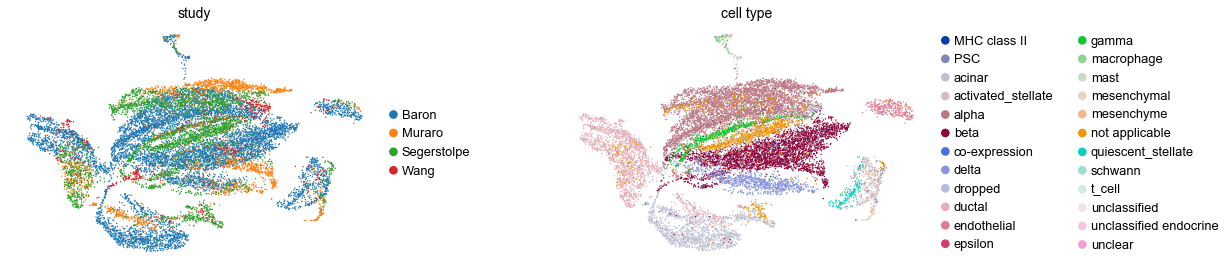

In [5]:
adata_cca = adata.copy()
adata_cca.obsm['X_pca'] = cca.values
sc.pp.neighbors(adata_cca)
sc.tl.umap(adata_cca)
adata_cca.obs["study"] = adata_cca.obs["sample"]
adata_cca.obs["cell type"] = adata_cca.obs["celltype"]
sc.pl.umap(adata_cca, color=['study','cell type'],save="CCA_correct.pdf",frameon=False)

In [1]:
import sklearn as sk 


In [4]:
X = adata_cca.obsm["X_pca"]
labels = adata_cca.obs["batch"].tolist()
print(f"average silhouette_score for cca :{sk.metrics.silhouette_score(X,labels)}")

average silhouette_score for cca :-0.0009046235353765612
